In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import time
import copy

c:\Users\35196\miniconda3\envs\IST_DL21_Env\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Impossível localizar o procedimento especificado'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
c:\Users\35196\miniconda3\envs\IST_DL21_Env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


If this prints 'cpu' is because you didnt activate cuda:0 (wich makes the usage of the gpu more simple for pytorch)
Dont worry, if you are using cpu anyway, this is just to be compatible if you decide to extend this code for
gpu aswell. You now just need to work with this device variable

In [4]:
# Transform for MNIST
mnist_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

# TRAIN AND VALIDATION DATA SET
mnist_train_dataset = datasets.MNIST('../data', download=True, train=True, transform=mnist_transform)
mnist_val_dataset = datasets.MNIST('../data', download=True, train=False, transform=mnist_transform)

# DATA LOADERS
mnist_train_dataloader = DataLoader(mnist_train_dataset, batch_size=64, shuffle=True)
mnist_val_dataloader = DataLoader(mnist_val_dataset, batch_size=64, shuffle=True)

# Question one: 

```c 
(1) Implement a Logistic Regression using scikit-learn and a Feedforward Neural Network
with 3 hidden layers of dimensions 256, 128, 64, using pytorch.

(2) Train the Feedforward Neural Network using as optimizer SGD with
a learning rate of 0.01 and a momentum 0.5,
nn.NLLLoss() as your loss function. Train the Feedforward
Neural Network using as optimizer SGD with a learning rate of 0.01 and a momentum 0.5,
nn.NLLLoss() as your loss function.

(3) Run your implementation of the Logistic Regression and the Feedforward Neural Network
algorithms on this dataset. Measure the training and validation accuracy

(4) Plot the coefficients of the Logistic Regression for each class
```

In [5]:
# MNIST Dataloaders to get data into numpy for Logistic Regression
mnist_train_dataloader_numpy = DataLoader(mnist_train_dataset, batch_size=len(mnist_train_dataset))
mnist_val_dataloader_numpy = DataLoader(mnist_val_dataset, batch_size=len(mnist_val_dataset))
X_y_train = next(iter(mnist_train_dataloader_numpy))
X_y_val = next(iter(mnist_val_dataloader_numpy))
X_train = X_y_train[0].numpy()
y_train = X_y_train[1].numpy()
X_val = X_y_val[0].numpy()
y_val = X_y_val[1].numpy()

dataloaders = dict(train=mnist_train_dataloader, val=mnist_val_dataloader)

In [6]:
# MNIST DATASET BASIC INFO

batch_idx, (example_imgs, example_targets) = next(enumerate(mnist_train_dataloader))

D_in = np.prod(example_imgs.shape[1:])
D_out = len(mnist_train_dataloader.dataset.targets.unique())
print("Datasets shapes:", {x: dataloaders[x].dataset.data.shape for x in ['train', 'val']})
print("N input features:", D_in, "Output classes:", D_out)
print("Train batch:", example_imgs.shape, example_targets.shape)
batch_idx, (example_imgs, example_targets) = next(enumerate(mnist_val_dataloader))
print("Val batch:", example_imgs.shape, example_targets.shape)

Datasets shapes: {'train': torch.Size([60000, 28, 28]), 'val': torch.Size([10000, 28, 28])}
N input features: 784 Output classes: 10
Train batch: torch.Size([64, 1, 28, 28]) torch.Size([64])
Val batch: torch.Size([64, 1, 28, 28]) torch.Size([64])


C:\Users\35196\AppData\Local\Temp\ipykernel_21044\2130928424.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


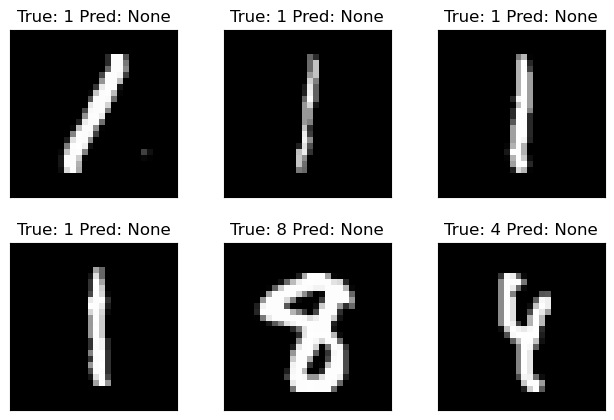

In [7]:
def plot_img_label_prediction(imgs, y_true, y_pred=None, shape=(2, 3)):
    y_pred = [None] * len(y_true) if y_pred is None else y_pred
    fig = plt.figure()
    for i in range(np.prod(shape)):
        plt.subplot(*shape, i+1)
        plt.tight_layout()
        plt.imshow(imgs[i][0], cmap='gray', interpolation='none')
        plt.title("True: {} Pred: {}".format(y_true[i], y_pred[i]))
        plt.xticks([])
        plt.yticks([])

plot_img_label_prediction(imgs=example_imgs, y_true=example_targets, y_pred=None, shape=(2, 3))

### 1.1 Logistic Regression

We can use a very simple Logistic Regression that receives our input images as a vector and predicts the digit. This will be our first baseline to compare with the CNNs.

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(np.reshape(X_train, (X_train.shape[0], -1)))
X_val = scaler.transform(np.reshape(X_val, (X_val.shape[0], -1)))

clf = LogisticRegression(C=50., multi_class='multinomial', solver='sag', tol=0.1)
clf.fit(X_train, y_train)
score = clf.score(X_val, y_val)

print("Test score with penalty: %.4f" % score)

Test score with penalty: 0.9000


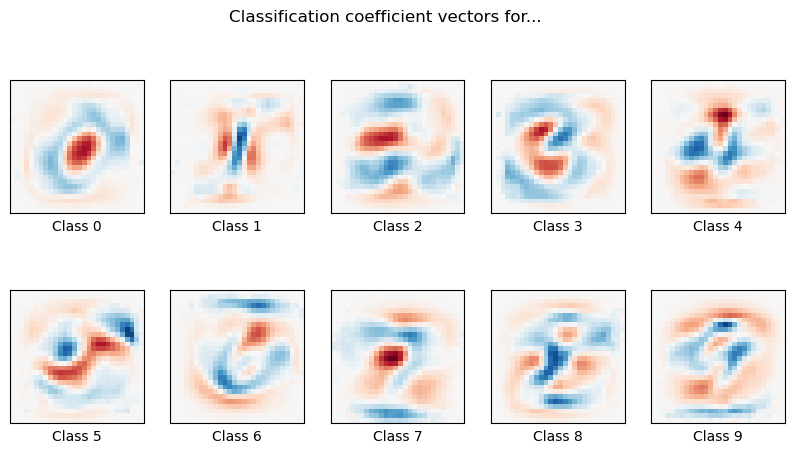

In [9]:
coef = clf.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(coef[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('Class %i' % i)
plt.suptitle('Classification coefficient vectors for...')

plt.show()

### 1.2 FF network

In [10]:
# MLP CLASS

class MLP(nn.Module):
    def __init__(self, dim_layers):
        super(MLP, self).__init__()
        self.dim_layers = dim_layers
        layer_list = [nn.Linear(dim_layers[l], dim_layers[l+1]) for l in range(len(dim_layers) - 1)]
        self.lin_layers = nn.ModuleList(layer_list)

    def forward(self, X):
        X = X.view(-1, self.dim_layers[0])
        # apply relu
        for layer in self.lin_layers[:-1]:
            X = F.relu(layer(X))
        # use softmax for output layer
        return F.log_softmax(self.lin_layers[-1](X), dim=1)

In [11]:
def train_val_model(model, criterion, optimizer, dataloaders, num_epochs=25,
        scheduler=None, log_interval=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # init dictionaries to save losses and accuracies of training and validation
    losses, accuracies = dict(train=[], val=[]), dict(train=[], val=[])

    for epoch in range(num_epochs):
        if log_interval is not None and epoch % log_interval == 0:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        # execute a training and validation phase for each epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # set model to train mode
            else:
                model.eval()   # Set model to eval mode

            running_loss = 0.0
            running_corrects = 0

            # iterate over the data
            nsamples = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                nsamples += inputs.shape[0]

                # set the parameter gradients to zero
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # if in training phase, perform backward prop and optimize
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # increment loss and correct counts
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if scheduler is not None and phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / nsamples
            epoch_acc = running_corrects.double() / nsamples

            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            if log_interval is not None and epoch % log_interval == 0:
                print('{} Loss: {:.4f} Acc: {:.2f}%'.format(
                    phase, epoch_loss, 100 * epoch_acc))

            # deep copy the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        if log_interval is not None and epoch % log_interval == 0:
            print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.2f}%'.format(100 * best_acc))

    # load best model weights to return
    model.load_state_dict(best_model_wts)

    return model, losses, accuracies

Epoch 0/14
----------
train Loss: 0.8121 Acc: 76.31%
val Loss: 0.2928 Acc: 91.55%

Epoch 2/14
----------
train Loss: 0.1789 Acc: 94.77%
val Loss: 0.1546 Acc: 95.32%

Epoch 4/14
----------
train Loss: 0.1117 Acc: 96.67%
val Loss: 0.1099 Acc: 96.57%

Epoch 6/14
----------
train Loss: 0.0779 Acc: 97.72%
val Loss: 0.0940 Acc: 97.03%

Epoch 8/14
----------
train Loss: 0.0573 Acc: 98.36%
val Loss: 0.0820 Acc: 97.35%

Epoch 10/14
----------
train Loss: 0.0423 Acc: 98.77%
val Loss: 0.0723 Acc: 97.71%

Epoch 12/14
----------
train Loss: 0.0317 Acc: 99.15%
val Loss: 0.0684 Acc: 97.96%

Epoch 14/14
----------
train Loss: 0.0227 Acc: 99.40%
val Loss: 0.0681 Acc: 97.86%

Training complete in 4m 0s
Best val Acc: 97.96%


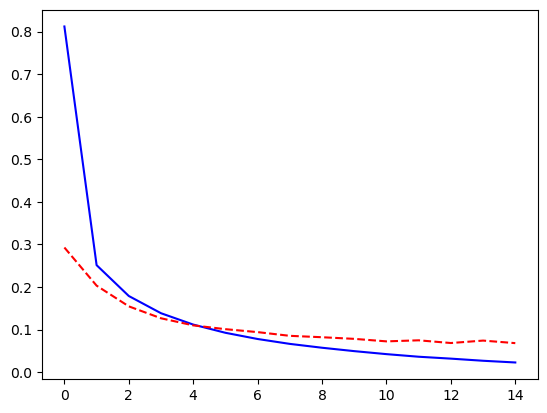

In [12]:
model_mlp = MLP([D_in, 256, 128, 64, D_out]).to(device) # [D_in, 512, 256, 128, 64, D_out]

optimizer = optim.SGD(model_mlp.parameters(), lr=0.01, momentum=0.5)
criterion = nn.NLLLoss()

model_mlp, losses, accuracies = train_val_model(model_mlp, criterion, optimizer, dataloaders,
                       num_epochs=15, log_interval=2)

_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

### 1.3 CNN 

In [13]:
class CNN(nn.Module):
    """Basic Pytorch CNN for MNIST-like data."""

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x, T=1.0):
        # Batch size = 64, images 28x28 =>
        #     x.shape = [64, 1, 28, 28]
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # Convolution with 5x5 filter without padding and 10 channels =>
        #     x.shape = [64, 10, 24, 24] since 24 = 28 - 5 + 1
        # Max pooling with stride of 2 =>
        #     x.shape = [64, 10, 12, 12]
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Convolution with 5x5 filter without padding and 20 channels =>
        #     x.shape = [64, 20, 8, 8] since 8 = 12 - 5 + 1
        # Max pooling with stride of 2 =>
        #     x.shape = [64, 20, 4, 4]
        x = x.view(-1, 320)
        # Reshape =>
        #     x.shape = [64, 320]
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

Epoch 0/24
----------
train Loss: 0.5508 Acc: 82.59%
val Loss: 0.1025 Acc: 96.77%

Epoch 2/24
----------
train Loss: 0.2135 Acc: 93.67%
val Loss: 0.0622 Acc: 98.02%

Epoch 4/24
----------
train Loss: 0.1731 Acc: 94.84%
val Loss: 0.0476 Acc: 98.51%

Epoch 6/24
----------
train Loss: 0.1565 Acc: 95.48%
val Loss: 0.0423 Acc: 98.54%

Epoch 8/24
----------
train Loss: 0.1412 Acc: 95.89%
val Loss: 0.0390 Acc: 98.84%

Epoch 10/24
----------
train Loss: 0.1308 Acc: 96.17%
val Loss: 0.0337 Acc: 98.85%

Epoch 12/24
----------
train Loss: 0.1243 Acc: 96.28%
val Loss: 0.0342 Acc: 98.91%

Epoch 14/24
----------
train Loss: 0.1190 Acc: 96.46%
val Loss: 0.0331 Acc: 98.99%

Epoch 16/24
----------
train Loss: 0.1152 Acc: 96.56%
val Loss: 0.0318 Acc: 99.04%

Epoch 18/24
----------
train Loss: 0.1109 Acc: 96.64%
val Loss: 0.0300 Acc: 98.99%

Epoch 20/24
----------
train Loss: 0.1072 Acc: 96.73%
val Loss: 0.0289 Acc: 99.05%

Epoch 22/24
----------
train Loss: 0.1013 Acc: 97.00%
val Loss: 0.0284 Acc: 99.08

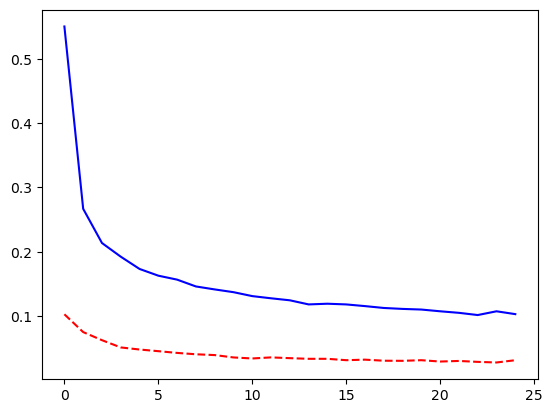

In [14]:
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders,
                       num_epochs=25, log_interval=2)

_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

In [15]:
# NUMBER OF PARAMETERS 

model_parameters_mlp = filter(lambda p: p.requires_grad, model_mlp.parameters())
params_mlp = sum([np.prod(p.size()) for p in model_parameters_mlp])
print('Number of parameters in the MLP model: {}'.format(params_mlp))

model_parameters_cnn = filter(lambda p: p.requires_grad, model.parameters())
params_cnn = sum([np.prod(p.size()) for p in model_parameters_cnn])
print('Number of parameters in the CNN model: {}'.format(params_cnn))

Number of parameters in the MLP model: 242762
Number of parameters in the CNN model: 21840
